# 從資料市集 下載資料

https://scidm.nchc.org.tw/dataset/datacon2019clipper

In [11]:
import requests
sample_data_list = [
    ("rabbit.jpg",'https://scidm.nchc.org.tw/dataset/140449f2-d6dc-4e96-9687-37e31c944d16/resource/5e5eab95-ac09-43d3-ac91-44b395250050/download/rabbit.jpg'),
    ("star1.jpg","https://scidm.nchc.org.tw/dataset/140449f2-d6dc-4e96-9687-37e31c944d16/resource/5af0f43c-6320-4c15-a185-d61ac7c8a9b8/download/star1.jpg"),
    ("su3.jpg","https://scidm.nchc.org.tw/dataset/140449f2-d6dc-4e96-9687-37e31c944d16/resource/e7f72116-e0f0-49fa-aca2-d3020327c9ad/download/su3.jpg"),
    ("1man.jpg","https://scidm.nchc.org.tw/dataset/140449f2-d6dc-4e96-9687-37e31c944d16/resource/67e34ad1-ef93-41e3-b327-3ec4d72bbd3c/download/1man2.jpg"),
    ("whale.jpg","https://scidm.nchc.org.tw/dataset/140449f2-d6dc-4e96-9687-37e31c944d16/resource/49cd759a-862f-4804-ba11-04b156f75903/download/whale.jpg"),
    ("elephant.jpg","https://scidm.nchc.org.tw/dataset/140449f2-d6dc-4e96-9687-37e31c944d16/resource/c71bd039-794d-4a7e-9e74-6c70bb711d4b/download/elephant.jpg"),
    ("diabetes.txt","https://scidm.nchc.org.tw/dataset/140449f2-d6dc-4e96-9687-37e31c944d16/resource/6ad066a8-dd4b-4572-bba1-ef37626a4d84/download/diabetes.txt")
]
for input_data in sample_data_list :
    r = requests.get(input_data[1])
    print(str(input_data[0]) + "=>" + str(r.status_code))
    with open(input_data[0],'wb') as f:
        f.write(r.content)

rabbit.jpg=>200
star1.jpg=>200
su3.jpg=>200
1man.jpg=>200
whale.jpg=>200
elephant.jpg=>200
diabetes.txt=>200


# apache clipper 
## demo 3 : Image prediction

# Load a pretrained Keras model(ResNet50)

In [1]:
# https://keras.io/applications/#classify-imagenet-classes-with-resnet50
from keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet')

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


# Initialize the Clipper cluster

In [2]:
from clipper_admin import ClipperConnection, DockerContainerManager

In [3]:
clipper_conn = ClipperConnection(DockerContainerManager())

In [4]:
from clipper_admin import ClipperException
try:
    clipper_conn.start_clipper()
except ClipperException as e:
    clipper_conn.connect()
except Exception as e:
    print(e)

19-09-05:09:55:54 WARNING  [clipper_admin.py:141] [default-cluster] Error starting Clipper: Cluster default-cluster cannot be started because it already exists. Please use ClipperConnection.connect() to connect to it.
19-09-05:09:55:54 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [5]:
!docker ps 

CONTAINER ID        IMAGE                                             COMMAND                  CREATED             STATUS                   PORTS                                            NAMES
2ea343e4d0c0        waue0920/default-cluster-image-example-string:2   "/container/containe…"   3 minutes ago       Up 2 minutes (healthy)                                                    image-example-string_2-99511
2f7ccc5af16b        default-cluster-image-example2:1                  "/container/containe…"   3 minutes ago       Up 3 minutes (healthy)                                                    image-example2_1-26514
cc876f160a89        waue0920/default-cluster-image-example:3          "/container/containe…"   4 minutes ago       Up 4 minutes (healthy)                                                    image-example_3-28896
4dc2635d165f        waue0920/default-cluster-waue-sum-model:2         "/container/containe…"   2 hours ago         Up 2 hours (healthy)                             

# Define 'predict' function

In [6]:
import io
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input, decode_predictions
    
def predict(model, inputs):
    def _predict_one(one_input_arr):
        try:
            image = Image.open(io.BytesIO(one_input_arr))
            if image.mode != "RGB":
                image = image.convert("RGB")
            image = image.resize((224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            return decode_predictions(preds=model.predict(image), top=3)[0]
        except Exception as e:
            print(e)
            return []
        
    return [_predict_one(i) for i in inputs]

# Deploy Keras model and 'predict' function to the Clipper cluster

In [7]:
import clipper_admin.deployers.keras as keras_deployer

note : you can choose one of the two method A.  or B.   

## A. deploy_keras_model + register_application + link_model_to_app

In [8]:
app_name = 'keras-test-app'
model_name = 'keras-test-model'

keras_deployer.deploy_keras_model(clipper_conn=clipper_conn,
                                  name=model_name,
                                  input_type='bytes',
                                  func=predict,
                                  model_path_or_object=model,
                                  registry="waue0920",
                                  version='1',
                                  num_replicas=1,
                                  batch_size=1,  # Disable adaptive batching policy
                                  pkgs_to_install=['pillow'])

19-09-05:09:55:56 INFO     [deployer_utils.py:41] Saving function to /tmp/tmp2tcv17jbclipper
19-09-05:09:55:56 INFO     [deployer_utils.py:51] Serialized and supplied predict function
19-09-05:09:56:03 INFO     [keras.py:221] Using Python 3.6 base image
19-09-05:09:56:03 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmp2tcv17jbclipper
19-09-05:09:56:06 INFO     [clipper_admin.py:539] [default-cluster] Step 1/3 : FROM clipper/keras36-container:0.4.1
19-09-05:09:56:06 INFO     [clipper_admin.py:539] [default-cluster]  ---> 5410d028b48e
19-09-05:09:56:06 INFO     [clipper_admin.py:539] [default-cluster] Step 2/3 : RUN apt-get -y install build-essential && pip install pillow
19-09-05:09:56:06 INFO     [clipper_admin.py:539] [default-cluster]  ---> Using cache
19-09-05:09:56:06 INFO     [clipper_admin.py:539] [default-cluster]  ---> b1064a1589bf
19-09-05:09:56:06 INFO     [clipper_admin.py:539] [default-cluster] Step 3/3 : COPY /tmp/

In [9]:
clipper_conn.register_application(name=app_name,
                                  input_type="bytes",
                                  default_output="-1.0",
                                  slo_micros=10000000)  # 10s

19-09-05:09:56:35 INFO     [clipper_admin.py:236] [default-cluster] Application keras-test-app was successfully registered


In [10]:
clipper_conn.link_model_to_app(app_name=app_name,
                               model_name=model_name)

19-09-05:09:56:35 INFO     [clipper_admin.py:303] [default-cluster] Model keras-test-model is now linked to application keras-test-app


## B. create_endpoint method

In [11]:
keras_deployer.create_endpoint(   clipper_conn=clipper_conn,
                                  name="keras-model2",
                                  input_type='bytes',
                                  func=predict,
                                  model_path_or_object=model,
                                  registry="waue0920",
                                  version='1',
                                  num_replicas=1,
                                  batch_size=1,  # Disable adaptive batching policy
                                  pkgs_to_install=['pillow'])

19-09-05:09:56:37 INFO     [clipper_admin.py:236] [default-cluster] Application keras-model2 was successfully registered
19-09-05:09:56:37 INFO     [deployer_utils.py:41] Saving function to /tmp/tmpq6id9ermclipper
19-09-05:09:56:37 INFO     [deployer_utils.py:51] Serialized and supplied predict function
19-09-05:09:56:37 INFO     [keras.py:221] Using Python 3.6 base image
19-09-05:09:56:37 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmpq6id9ermclipper
19-09-05:09:56:39 INFO     [clipper_admin.py:539] [default-cluster] Step 1/3 : FROM clipper/keras36-container:0.4.1
19-09-05:09:56:39 INFO     [clipper_admin.py:539] [default-cluster]  ---> 5410d028b48e
19-09-05:09:56:39 INFO     [clipper_admin.py:539] [default-cluster] Step 2/3 : RUN apt-get -y install build-essential && pip install pillow
19-09-05:09:56:39 INFO     [clipper_admin.py:539] [default-cluster]  ---> Using cache
19-09-05:09:56:39 INFO     [clipper_admin.py:539] [defa

In [12]:
clipper_conn.get_all_apps()

['keras-model2',
 'image-example2',
 'hello-world',
 'image-example-string',
 'keras-test-app',
 'image-example']

# Download sample images

In [13]:
!wget https://harishnarayanan.org/images/writing/artistic-style-transfer/output_13_0.png -O elephant.jpg

--2019-09-05 09:57:07--  https://harishnarayanan.org/images/writing/artistic-style-transfer/output_13_0.png
Resolving harishnarayanan.org (harishnarayanan.org)... 46.101.13.93
Connecting to harishnarayanan.org (harishnarayanan.org)|46.101.13.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111477 (109K) [image/png]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>] 108.86K   199KB/s    in 0.5s    

2019-09-05 09:57:09 (199 KB/s) - ‘elephant.jpg’ saved [111477/111477]



In [14]:
!wget http://kikei.github.io/images/plots/2018-08-05-rabbit2.jpg -O rabbit.jpg

--2019-09-05 09:57:09--  http://kikei.github.io/images/plots/2018-08-05-rabbit2.jpg
Resolving kikei.github.io (kikei.github.io)... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to kikei.github.io (kikei.github.io)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22976 (22K) [image/jpeg]
Saving to: ‘rabbit.jpg’

rabbit.jpg          100%[===================>]  22.44K  --.-KB/s    in 0.03s   

2019-09-05 09:57:10 (706 KB/s) - ‘rabbit.jpg’ saved [22976/22976]



In [15]:
from IPython.display import display
from PIL import Image

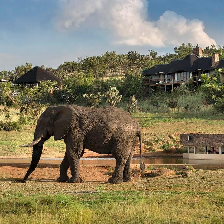

In [16]:
display(Image.open('elephant.jpg'))

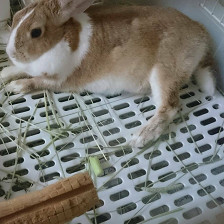

In [17]:
display(Image.open('rabbit.jpg'))

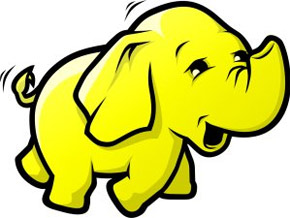

In [18]:
display(Image.open('hadoop.jpg'))

# Send some requests to the Clipper cluster

In [19]:
import json
import base64
import requests
from datetime import datetime
from keras.preprocessing import image

In [39]:
headers = {'Content-type': 'application/json'}
url = "http://{addr}/{app_name}/predict".format(
    addr=clipper_conn.get_query_addr(),
    app_name=app_name)

### First request, which is so slow due to downloading a file from https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json.

In [40]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('elephant.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [41]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":20,"output":"[('n02504458', 'African_elephant', 0.65733784), ('n01871265', 'tusker', 0.14728823), ('n02504013', 'Indian_elephant', 0.13633111)]","default":false}', 5.692000 ms


### Second request, which is moderate!

In [42]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('rabbit.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [43]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":21,"output":"[('n02328150', 'Angora', 0.66698086), ('n02326432', 'hare', 0.22042108), ('n02325366', 'wood_rabbit', 0.09336065)]","default":false}', 3.694000 ms


## Third request, 

In [44]:
headers = {'Content-type': 'application/json'}
url = "http://{addr}/{app_name}/predict".format(
    addr=clipper_conn.get_query_addr(),
    app_name="keras-model2")

In [45]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('hadoop.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [46]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":22,"output":"[('n06596364', 'comic_book', 0.3934667), ('n04317175', 'stethoscope', 0.073557295), ('n06359193', 'web_site', 0.03299896)]","default":false}', 927.815000 ms


## forth request, 

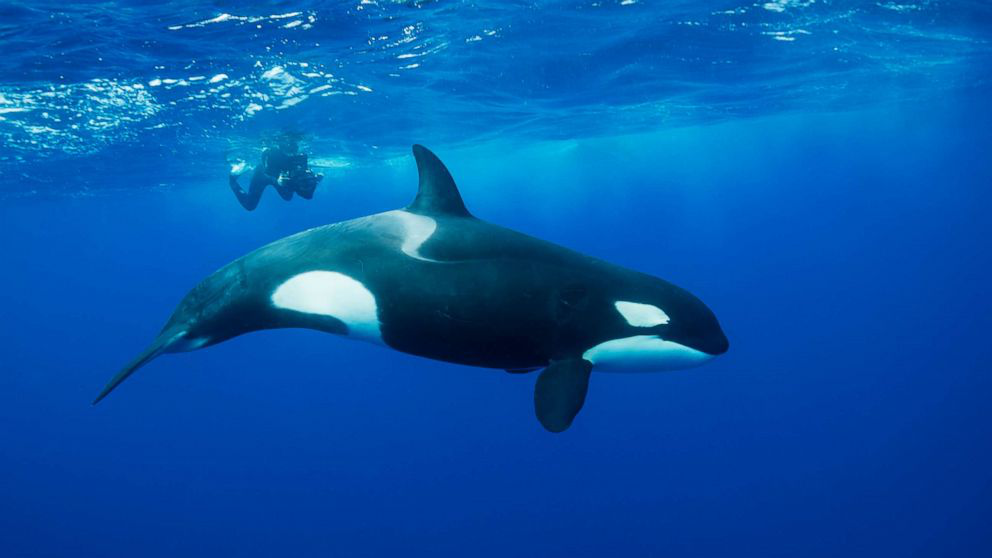

In [47]:
display(Image.open('whale.jpg'))

In [48]:
headers = {'Content-type': 'application/json'}
url = "http://{addr}/{app_name}/predict".format(
    addr=clipper_conn.get_query_addr(),
    app_name="keras-model2")

In [49]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('whale.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [50]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":23,"output":"[('n02071294', 'killer_whale', 0.99937516), ('n02056570', 'king_penguin', 0.0003414938), ('n01484850', 'great_white_shark', 0.00022703268)]","default":false}', 93.605000 ms


## fifth request, 

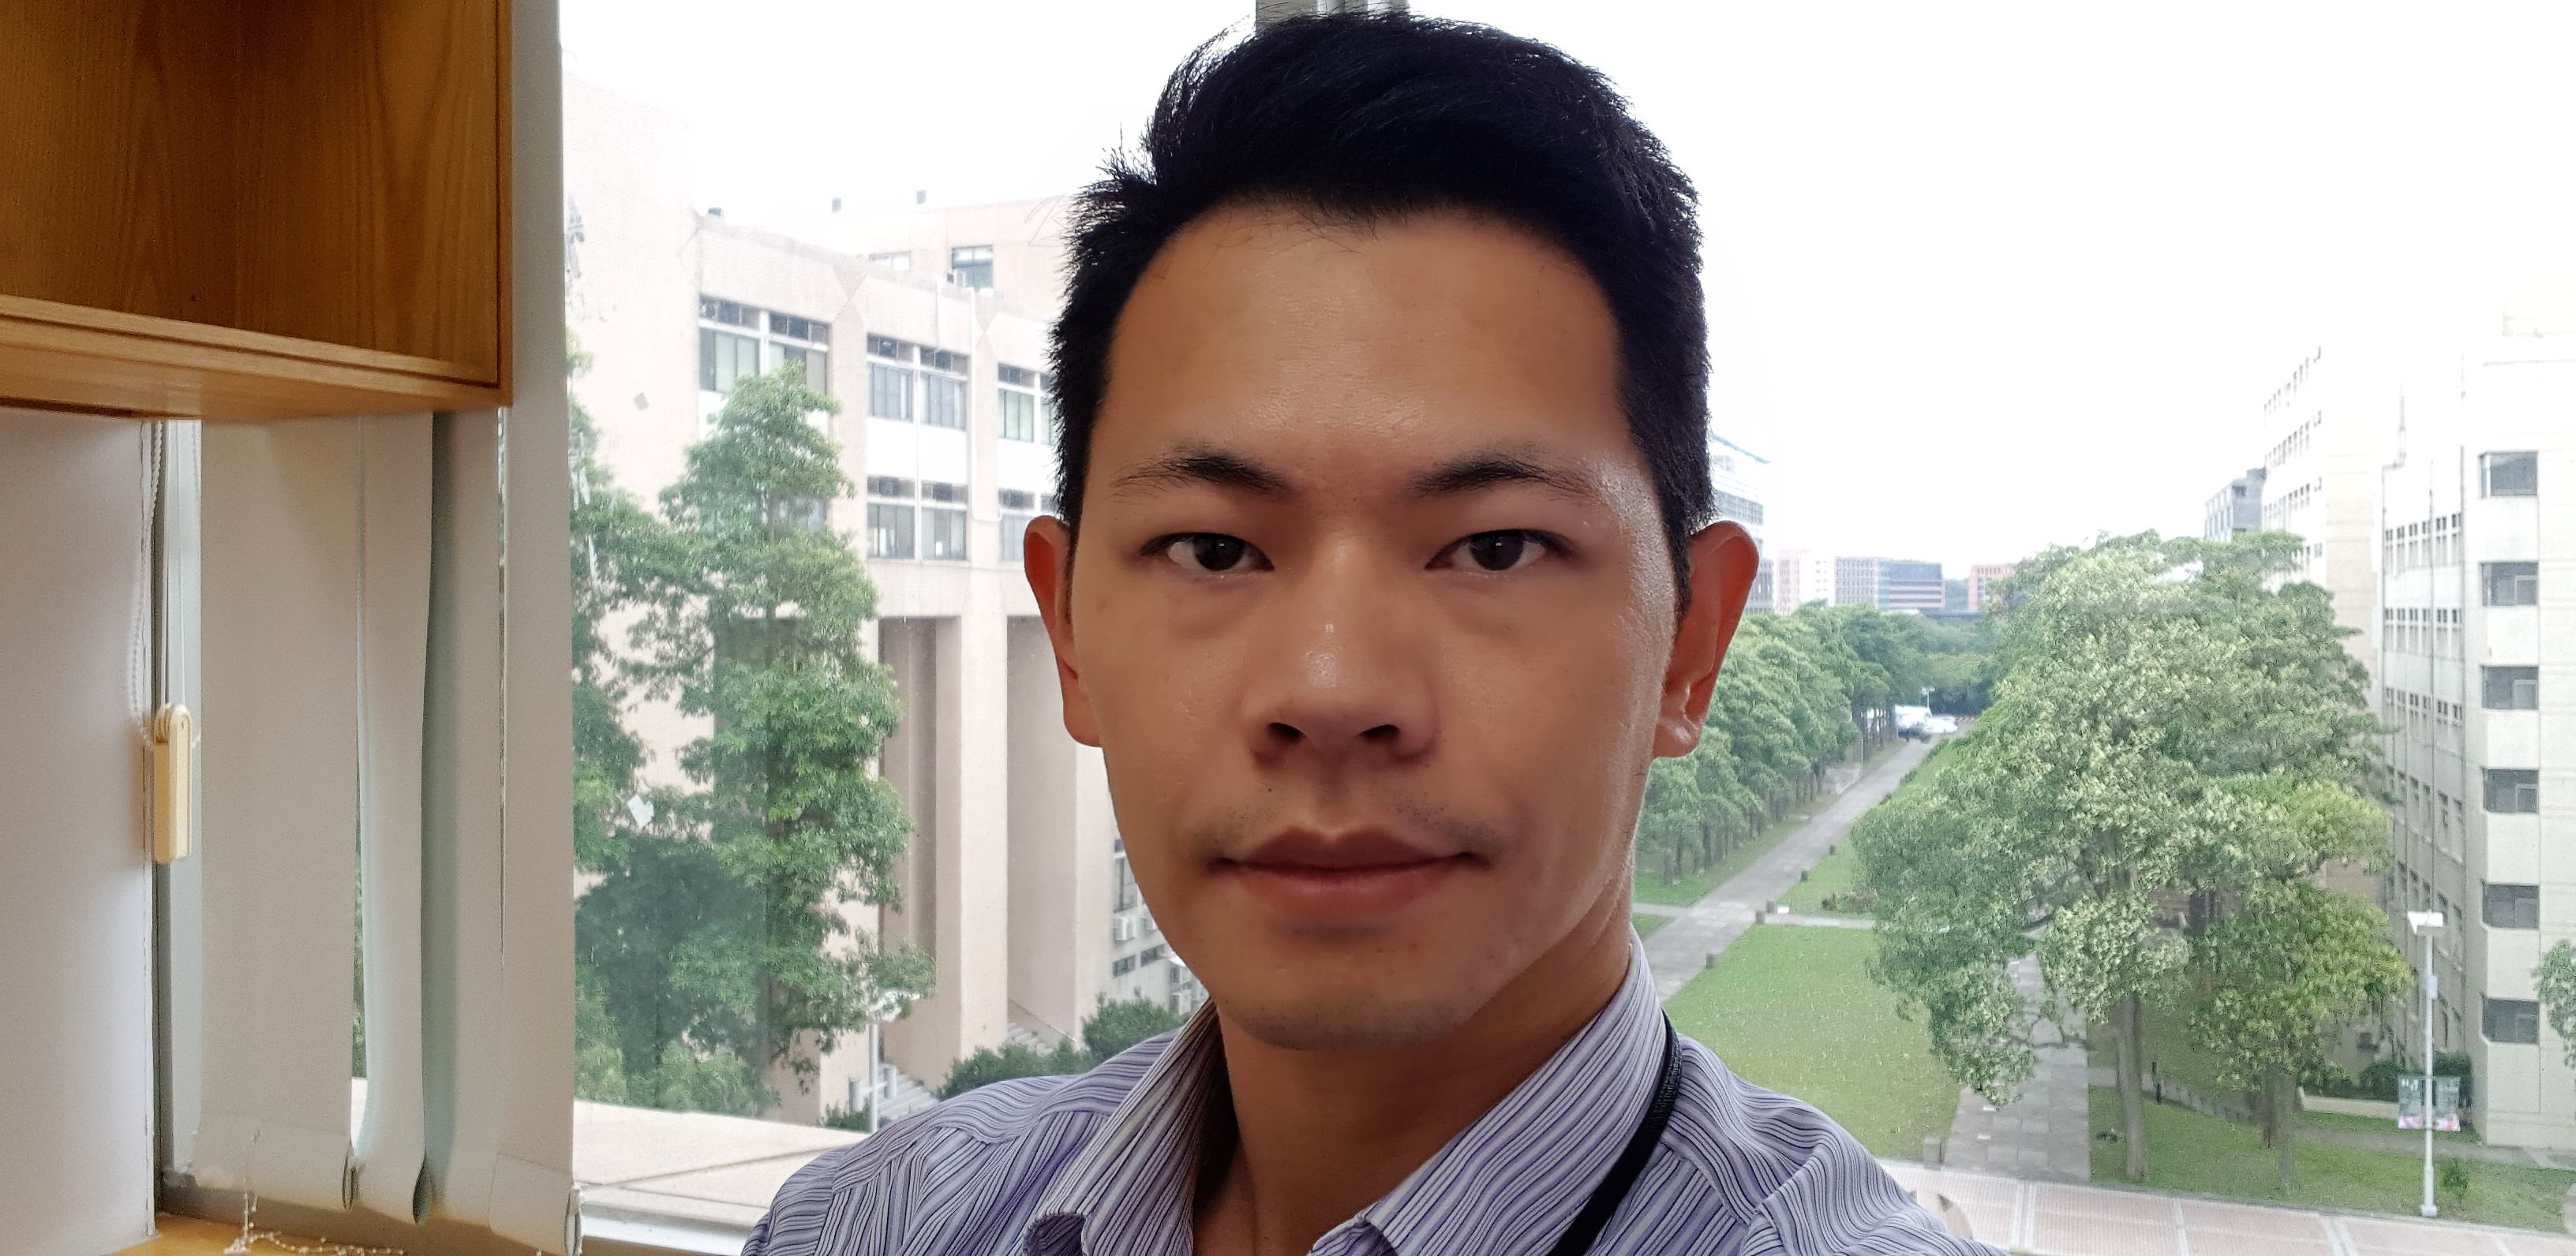

In [51]:
display(Image.open('waue.jpg'))

In [52]:
headers = {'Content-type': 'application/json'}
url = "http://{addr}/{app_name}/predict".format(
    addr=clipper_conn.get_query_addr(),
    app_name="keras-model2")

In [53]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('waue.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [54]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":24,"output":"[('n03000247', 'chain_mail', 0.2766262), ('n02963159', 'cardigan', 0.2259612), ('n03594734', 'jean', 0.11207032)]","default":false}', 162.856000 ms


# Clean-up

clipper_conn.stop_all()

!docker rm -f $(docker ps -a -q) && docker image prune -f